In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models
from torchvision.models import resnet50
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
data_path = '/kaggle/input/us-license-plates-image-classification/new plates'

In [4]:
class_name = os.listdir(data_path +'/train')
print(class_name)

csv_path = data_path + "/plates.csv"

df = pd.read_csv(csv_path)  # Read the CSV file into a pandas DataFrame
print(df.head())  # Print the first few rows

['KENTUCKY', 'WISCONSIN', 'OKLAHOMA', 'WASHINGTON DC', 'NEW YORK', 'ALASKA', 'NEW JERSEY', 'COLORADO', 'HAWAI', 'UTAH', 'OHIO', 'VIRGINIA', 'LOUISIANA', 'IDAHO', 'ARIZONA', 'OREGON', 'INDIANA', 'CNMI', 'MASSACHUSETTS', 'WASHINGTON', 'PUERTO RICO', 'MONTANA', 'MINNESOTA', 'MARYLAND', 'U S VIRGIN ISLANDS', 'WEST VIRGINIA', 'NORTH DAKOTA', 'NEW HAMPSHIRE', 'MAINE', 'SOUTH CAROLINA', 'MICHIGAN', 'KANSAS', 'CALIFORNIA', 'RHODE ISLAND', 'SOUTH DAKOTA', 'ALABAMA', 'MISSIPPI', 'AMERICAN SAMOA', 'TENNESSEE', 'MISSOURI', 'NORTH CAROLINA', 'GEORGIA', 'NEW MEXICO', 'NEBRASKA', 'CONNECTICUT', 'WYOMING', 'FLORIDA', 'ILLINOIS', 'PENNSYLVANIA', 'TEXAS', 'VERMONT', 'DELAWARE', 'ARKANSAS', 'GUAM', 'IOWA', 'NEVADA']
   class id              filepaths   labels data set
0         0  train/ALABAMA/001.jpg  ALABAMA    train
1         0  train/ALABAMA/002.jpg  ALABAMA    train
2         0  train/ALABAMA/003.jpg  ALABAMA    train
3         0  train/ALABAMA/004.jpg  ALABAMA    train
4         0  train/ALABAMA/0

In [5]:
class CustomDataset(Dataset):
    # 0001.jpg, 0
    # 0001.jpg, [1,0,0,0,0,0,0, ...]
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        # 1 hot encoding setup
        label_idx = self.labels[idx]
        label = torch.zeros(56)
        label[label_idx] = 1

        # Load the image
        image = Image.open('/kaggle/input/us-license-plates-image-classification/new plates/'+image_path)


        # Define transformations
        transform = transforms.Compose([
            transforms.Resize(224),      # Resize the shorter side to 224 pixels
            transforms.CenterCrop(224),  # Crop the center to 224x224
            transforms.ToTensor()        # Convert to tensor
        ])
    
        # Apply transformations
        tensor_image = transform(image)

        return tensor_image, label, image_path

In [6]:
df_train = df[df["data set"] == "train"][["filepaths", "class id"]]
train_data = CustomDataset(df_train["filepaths"], df_train["class id"])

df_test = df[df["data set"] == "test"][["filepaths", "class id"]].reset_index(drop=True)
test_data = CustomDataset(df_test["filepaths"], df_test["class id"])

df_valid = df[df["data set"] == "valid"][["filepaths", "class id"]].reset_index(drop=True)
valid_data = CustomDataset(df_valid["filepaths"], df_valid["class id"])

# print a sample image
print(train_data.__getitem__(0))
print(test_data.__getitem__(0))
print(valid_data.__getitem__(0))

dl_train = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory = True, num_workers=4)
dl_test = DataLoader(test_data, batch_size=32, shuffle=True, pin_memory = True, num_workers=4)
dl_valid = DataLoader(valid_data, batch_size=1, shuffle=True, pin_memory = True, num_workers=4)

print(f'train images count: {len(train_data)}')
print(f'test images count: {len(test_data)}')
print(f'valid images count: {len(valid_data)}')

(tensor([[[0.7608, 0.7647, 0.7686,  ..., 0.6784, 0.6745, 0.6745],
         [0.7804, 0.7804, 0.7804,  ..., 0.6863, 0.6863, 0.6863],
         [0.8078, 0.8039, 0.8000,  ..., 0.6980, 0.7059, 0.7059],
         ...,
         [0.7882, 0.7843, 0.7765,  ..., 0.3647, 0.3804, 0.3843],
         [0.7098, 0.7059, 0.7020,  ..., 0.4745, 0.4784, 0.4824],
         [0.6588, 0.6588, 0.6549,  ..., 0.5451, 0.5412, 0.5451]],

        [[0.7333, 0.7373, 0.7412,  ..., 0.6667, 0.6627, 0.6627],
         [0.7529, 0.7529, 0.7529,  ..., 0.6706, 0.6706, 0.6706],
         [0.7804, 0.7765, 0.7725,  ..., 0.6784, 0.6863, 0.6863],
         ...,
         [0.7608, 0.7569, 0.7490,  ..., 0.3529, 0.3647, 0.3686],
         [0.6784, 0.6784, 0.6784,  ..., 0.4667, 0.4706, 0.4745],
         [0.6275, 0.6314, 0.6353,  ..., 0.5373, 0.5333, 0.5373]],

        [[0.6902, 0.6980, 0.7020,  ..., 0.5922, 0.5882, 0.5922],
         [0.7098, 0.7137, 0.7137,  ..., 0.5961, 0.6000, 0.6039],
         [0.7412, 0.7373, 0.7333,  ..., 0.6039, 0.6157, 0

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("device", device)

# initialize resnet50 model
model = resnet50()
model.fc = torch.nn.Linear(2048, 56)
model.to(device)

device cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
loss_fn = torch.nn.BCEWithLogitsLoss()
# loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(dataloader):
  # use tqdm for for loop
  progress = tqdm(dataloader)
  total_loss = 0

  for i, data in enumerate(progress):
    # extract data and label
    tensor_image, label, image_label = data

    # move data to the same device as the model
    tensor_image = tensor_image.to(device)
    label = label.to(device)

    # clear optimizer
    optimizer.zero_grad()

    # get the prediction from the current model
    output = model(tensor_image)

    # convert label from long to float (for BCE loss func)
    label = label.float()

    # calculate the loss
    loss = loss_fn(output, label)
    loss.backward()

    # update the weights of the model
    optimizer.step()

    # update total_loss value
    total_loss += loss.item()

    # add description to progress bar
    progress.set_description(f"batch: {i+1} | loss:{loss.item()}")

  avg_loss = total_loss / len(dataloader)
  return avg_loss  # Return average loss over all batches

In [16]:
def evaluate(dataloader):
    # use tqdm for for loop
    progress = tqdm(dataloader)
    total_loss = 0
    total_correct = 0
    total_sample = 0
    with torch.no_grad():
        for i, data in enumerate(progress):
            tensor_image, label, image_label = data
            # print(label.shape) # torch.Size([32, 56])
            
            # move data to the same device as the model
            tensor_image = tensor_image.to(device)
            label = label.to(device)

            output = model(tensor_image)
            true_classes = label.argmax(dim=1) 
            predicted_classes = output.argmax(dim=1) # shape: [32] w all max index
            # print(true_classes.shape, predicted_classes.shape) # torch.Size([32, 56])

            batch_correct = (predicted_classes == true_classes).sum().item()
            total_correct += batch_correct
            total_sample += label.shape[0]

            # Compute loss
            total_loss += loss_fn(output, label).item()

    avg_loss = total_loss / len(dl_test)
    accuracy = total_correct*100/total_sample
    # print(f"accuracy: {total_correct*100/total_sample}%")
    return avg_loss, accuracy


In [19]:
# training
EPOCHS = 25

avg_loss_log = []
# accuracy_log = []
avg_test_loss_log = []
test_accuracy_log = []

best_test_avg_loss = float('inf')
best_model_path = "/kaggle/working/best_model.pth"

for epoch in range(EPOCHS):
    model.train()
    print("EPOCH:", epoch)
    avg_loss = train_one_epoch(dl_train)
    print("avg loss:", avg_loss)
    avg_loss_log.append(avg_loss)

    model.eval()
    test_avg_loss, test_accuracy = evaluate(dl_test)
    print(f"avg test loss: {test_avg_loss}")
    print(f"accuracy: {test_accuracy}%")
    
    avg_test_loss_log.append(test_avg_loss)
    test_accuracy_log.append(test_accuracy)

    if test_avg_loss < best_test_avg_loss:
        best_test_avg_loss = test_avg_loss
        torch.save(model.state_dict(), best_model_path)
    
    print()

EPOCH: 0


batch: 256 | loss:0.09526760876178741: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.07131206308258697


100%|██████████| 9/9 [00:00<00:00, 11.64it/s]


avg test loss: 0.0762984992729293
accuracy: 19.285714285714285%

EPOCH: 1


batch: 256 | loss:0.24639050662517548: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.06636933371191844


100%|██████████| 9/9 [00:00<00:00, 11.50it/s]


avg test loss: 0.07473935931921005
accuracy: 25.714285714285715%

EPOCH: 2


batch: 256 | loss:0.13673138618469238: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s] 


avg loss: 0.06312870688270777


100%|██████████| 9/9 [00:00<00:00, 11.33it/s]


avg test loss: 0.06704367904199494
accuracy: 32.857142857142854%

EPOCH: 3


batch: 256 | loss:0.11361528187990189: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.05667793420434464


100%|██████████| 9/9 [00:00<00:00, 11.91it/s]


avg test loss: 0.06284255948331621
accuracy: 39.642857142857146%

EPOCH: 4


batch: 256 | loss:0.1311759054660797: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]  


avg loss: 0.05164544844592456


100%|██████████| 9/9 [00:00<00:00, 11.59it/s]


avg test loss: 0.062141707373989954
accuracy: 38.57142857142857%

EPOCH: 5


batch: 256 | loss:0.1523321121931076: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]  


avg loss: 0.04626566638762597


100%|██████████| 9/9 [00:00<00:00, 11.70it/s]


avg test loss: 0.06258912053373125
accuracy: 37.142857142857146%

EPOCH: 6


batch: 256 | loss:0.19206520915031433: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.04964146595739294


100%|██████████| 9/9 [00:00<00:00, 11.88it/s]


avg test loss: 0.08109947956270641
accuracy: 32.142857142857146%

EPOCH: 7


batch: 256 | loss:0.1593588888645172: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]  


avg loss: 0.03990441214409657


100%|██████████| 9/9 [00:00<00:00, 11.60it/s]


avg test loss: 0.046277006053262286
accuracy: 55.0%

EPOCH: 8


batch: 256 | loss:0.20481781661510468: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.035031978477491066


100%|██████████| 9/9 [00:00<00:00, 11.49it/s]


avg test loss: 0.09492569085624483
accuracy: 31.785714285714285%

EPOCH: 9


batch: 256 | loss:0.16760869324207306: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s] 


avg loss: 0.0326917258244066


100%|██████████| 9/9 [00:00<00:00, 11.68it/s]


avg test loss: 0.043587238838275276
accuracy: 60.357142857142854%

EPOCH: 10


batch: 256 | loss:0.12942075729370117: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s] 


avg loss: 0.026472028643183876


100%|██████████| 9/9 [00:00<00:00, 11.76it/s]


avg test loss: 0.04800183781319194
accuracy: 58.92857142857143%

EPOCH: 11


batch: 256 | loss:0.16211040318012238: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s] 


avg loss: 0.02294249967962969


100%|██████████| 9/9 [00:00<00:00, 11.96it/s]


avg test loss: 0.042550026956531734
accuracy: 60.714285714285715%

EPOCH: 12


batch: 256 | loss:0.21217750012874603: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s] 


avg loss: 0.01875192591251107


100%|██████████| 9/9 [00:00<00:00, 11.61it/s]


avg test loss: 0.03852439195745521
accuracy: 67.85714285714286%

EPOCH: 13


batch: 256 | loss:0.20767484605312347: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]  


avg loss: 0.01549527520819538


100%|██████████| 9/9 [00:00<00:00, 10.86it/s]


avg test loss: 0.034802735679679446
accuracy: 71.07142857142857%

EPOCH: 14


batch: 256 | loss:0.22355647385120392: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s]  


avg loss: 0.01425154509524873


100%|██████████| 9/9 [00:00<00:00, 11.66it/s]


avg test loss: 0.03536712150606844
accuracy: 73.92857142857143%

EPOCH: 15


batch: 256 | loss:0.2574096620082855: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]   


avg loss: 0.01196641581827862


100%|██████████| 9/9 [00:00<00:00, 11.52it/s]


avg test loss: 0.03389429383807712
accuracy: 72.85714285714286%

EPOCH: 16


batch: 256 | loss:0.22347243130207062: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]  


avg loss: 0.01051403054043476


100%|██████████| 9/9 [00:00<00:00, 12.05it/s]


avg test loss: 0.037512658163905144
accuracy: 70.0%

EPOCH: 17


batch: 256 | loss:0.22154414653778076: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]  


avg loss: 0.007529723839070357


100%|██████████| 9/9 [00:00<00:00, 12.10it/s]


avg test loss: 0.03856953833666113
accuracy: 75.35714285714286%

EPOCH: 18


batch: 256 | loss:0.22182303667068481: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]  


avg loss: 0.00804090734300189


100%|██████████| 9/9 [00:00<00:00, 11.75it/s]


avg test loss: 0.03393491937054528
accuracy: 75.71428571428571%

EPOCH: 19


batch: 256 | loss:0.2267669141292572: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]   


avg loss: 0.006159970696899109


100%|██████████| 9/9 [00:00<00:00, 11.79it/s]


avg test loss: 0.03603747424980005
accuracy: 75.35714285714286%

EPOCH: 20


batch: 256 | loss:0.2821211516857147: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]   


avg loss: 0.006252057071833406


100%|██████████| 9/9 [00:00<00:00, 11.75it/s]


avg test loss: 0.03516157757904795
accuracy: 74.64285714285714%

EPOCH: 21


batch: 256 | loss:0.3137285113334656: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s]   


avg loss: 0.006446106157909526


100%|██████████| 9/9 [00:00<00:00, 11.89it/s]


avg test loss: 0.027913425531652238
accuracy: 81.07142857142857%

EPOCH: 22


batch: 256 | loss:0.3995991349220276: 100%|██████████| 256/256 [00:43<00:00,  5.90it/s]   


avg loss: 0.00519527532230768


100%|██████████| 9/9 [00:00<00:00, 11.93it/s]


avg test loss: 0.03517304236690203
accuracy: 77.85714285714286%

EPOCH: 23


batch: 256 | loss:0.27013397216796875: 100%|██████████| 256/256 [00:43<00:00,  5.88it/s]   


avg loss: 0.004500119399267533


100%|██████████| 9/9 [00:00<00:00, 11.85it/s]


avg test loss: 0.03046065361963378
accuracy: 80.35714285714286%

EPOCH: 24


batch: 256 | loss:0.25796639919281006: 100%|██████████| 256/256 [00:43<00:00,  5.89it/s]   


avg loss: 0.003506935094151231


100%|██████████| 9/9 [00:00<00:00, 11.44it/s]

avg test loss: 0.03067910174528758
accuracy: 80.35714285714286%



In [21]:
# model.save('/kaggle/working/model.h5')
torch.save(model.state_dict(), best_model_path)

In [26]:
from torchvision.transforms.functional import to_pil_image

In [29]:
class_name = os.listdir(data_path +'/valid')
class_name.sort()
print(class_name)

['ALABAMA', 'ALASKA', 'AMERICAN SAMOA', 'ARIZONA', 'ARKANSAS', 'CALIFORNIA', 'CNMI', 'COLORADO', 'CONNECTICUT', 'DELAWARE', 'FLORIDA', 'GEORGIA', 'GUAM', 'HAWAI', 'IDAHO', 'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE', 'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA', 'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA', 'PUERTO RICO', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'U S VIRGIN ISLANDS', 'UTAH', 'VERMONT', 'VIRGINIA', 'WASHINGTON', 'WASHINGTON DC', 'WEST VIRGINIA', 'WISCONSIN', 'WYOMING']


<ipython-input-31-7ce9dd4fc0a8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


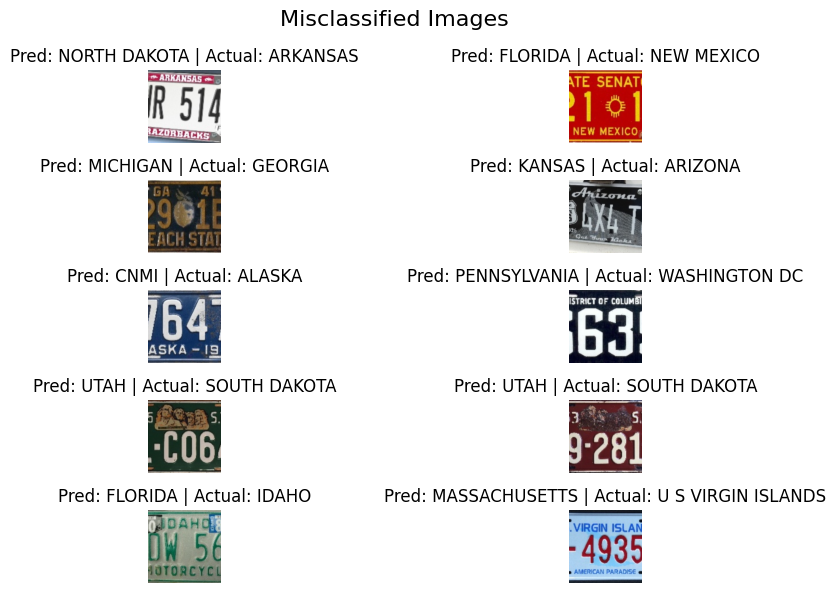

In [31]:
# see model's performance with validate datas
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

misclassified_images = []
misclassified_labels = []
misclassified_preds = []
misclassified_paths = []

with torch.no_grad():
    for data in dl_valid:
        tensor_image, label, image_path = data
        tensor_image = tensor_image.to(device)
        label = label.to(device)

        output = model(tensor_image)
        
        true_class = label.argmax(dim=1) 
        predicted_class = output.argmax(dim=1)

        if predicted_class != true_class: # wrong prediction
            misclassified_images.append(tensor_image.cpu())
            misclassified_labels.append(true_class.item())
            misclassified_preds.append(predicted_class.item())
            misclassified_paths.append(image_path[0])
            # misclassified_images.append(image_path)
            # misclassified_labels.append(predicted_class)
            # misclassified_preds.append(true_class)
            # misclassified_paths.append(image_path[0])

# Display misclassified images
num_display = min(10, len(misclassified_images))  # Display up to 10 images
fig, axes = plt.subplots(5, 2, figsize=(12, 6))  # Create 2x5 grid

fig.suptitle("Misclassified Images", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i < num_display:
        img = to_pil_image(misclassified_images[i].squeeze(0))  # Convert tensor to image
        ax.imshow(img)
        ax.set_title(f"Pred: {class_name[misclassified_preds[i]]} | Actual: {class_name[misclassified_labels[i]]}")
        ax.axis("off")

plt.tight_layout()
plt.show()

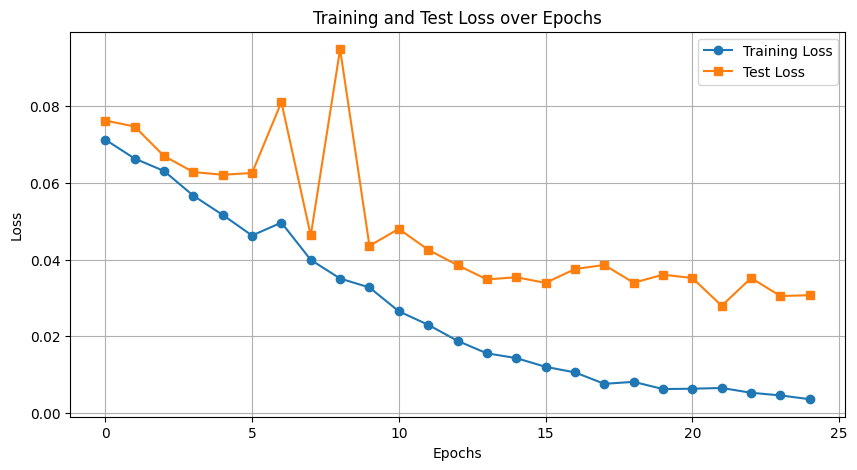

In [32]:
# Plot training and test loss
plt.figure(figsize=(10, 5))
plt.plot(avg_loss_log, label='Training Loss', marker='o')
plt.plot(avg_test_loss_log, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

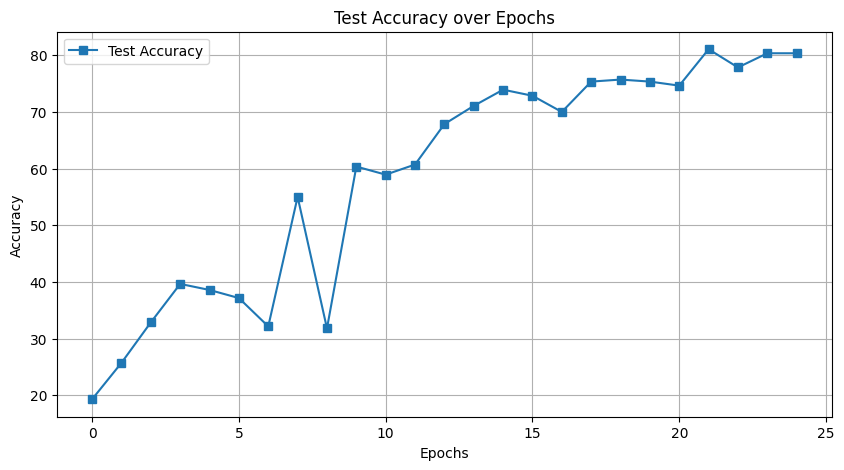

In [33]:
# Plot training and test loss
plt.figure(figsize=(10, 5))
plt.plot(test_accuracy_log, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()